# Import Necessary Libraries 

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Load The Data 

In [52]:
df = pd.read_csv(r'../data/v3_Feature_Selection.csv')
df.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2


In [53]:
# Now we'll create a new feature to help us detect outliers in our data.
df['price_per_sqft'] = df['price']*100000/df['total_sqft']
df.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


In [54]:
# Now let's check how many locations in my dataset
df.location.unique()

<StringArray>
[                       'Electronic City Phase II',
                                'Chikka Tirupathi',
                                     'Uttarahalli',
                              'Lingadheeranahalli',
                                        'Kothanur',
                                      'Whitefield',
                                'Old Airport Road',
                                    'Rajaji Nagar',
                                    'Marathahalli',
                              '7th Phase JP Nagar',
 ...
                                   'Kavika Layout',
                                        'Zuzuvadi',
                           'Kanakapura main  Road',
                                   'Sindhi Colony',
                             'Kanakapur main road',
                       'Prasanna layout Herohalli',
                               'Sarvobhogam Nagar',
 '12th cross srinivas nagar banshankari 3rd stage',
                               'Havanur exten

In [55]:
len(df.location.unique())

1215

In [56]:
# Let's see how many data points are available in location
df.location = df.location.apply(lambda x: x.strip())

location_stage = df.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stage

location
Whitefield                     520
Sarjapur  Road                 373
Electronic City                281
Kanakpura Road                 245
Thanisandra                    230
                              ... 
Kannur                           1
Karnataka Shabarimala            1
Kasthuri Nagar East Of NGEF      1
Kathreguppe                      1
whitefiled                       1
Name: location, Length: 1205, dtype: int64

In [57]:
# as we can see here Whitefield has 520 location 
# Now let's see how many locations less than 10 data points
len(location_stage[location_stage<=10])

991

In [58]:
location_stage_less_then_10 = location_stage[location_stage <= 10]
location_stage_less_then_10

location
1st Block Jayanagar            10
Dodsworth Layout               10
Kalkere                        10
Tindlu                         10
Nagappa Reddy Layout           10
                               ..
Kannur                          1
Karnataka Shabarimala           1
Kasthuri Nagar East Of NGEF     1
Kathreguppe                     1
whitefiled                      1
Name: location, Length: 991, dtype: int64

In [59]:
len(df.location.unique())

1205

In [60]:
df.location = df.location.apply(lambda x: 'other' if x in location_stage_less_then_10 else x)
len(df.location.unique())

215

In [61]:
df.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


<h3 style='color:white'>Outlier Removal Using Standard Deviation and Mean</h3>

In [62]:
# Outlier Removal Using Standard Deviation and Mean
df.price_per_sqft.describe()

count     11994.000000
mean       6367.093016
std        4225.378242
min         267.829813
25%        4250.000000
50%        5333.333333
75%        6969.451337
max      176470.588235
Name: price_per_sqft, dtype: float64

Here we find that min price per sqft is 267 rs/sqft whereas max is 176470, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [63]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df = remove_pps_outliers(df)
df.shape

(9914, 6)

Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

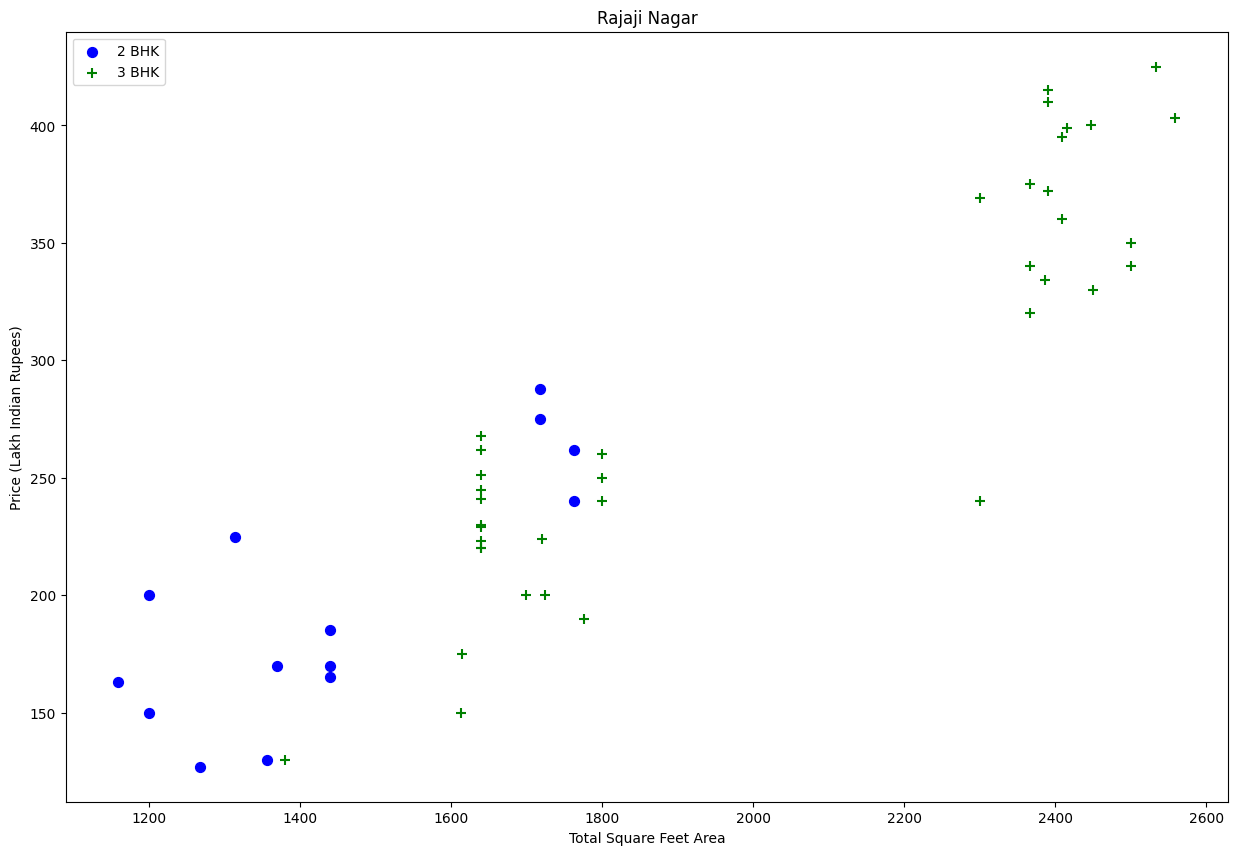

In [64]:
import matplotlib
def plot_scatter_chart(df, location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df,"Rajaji Nagar")

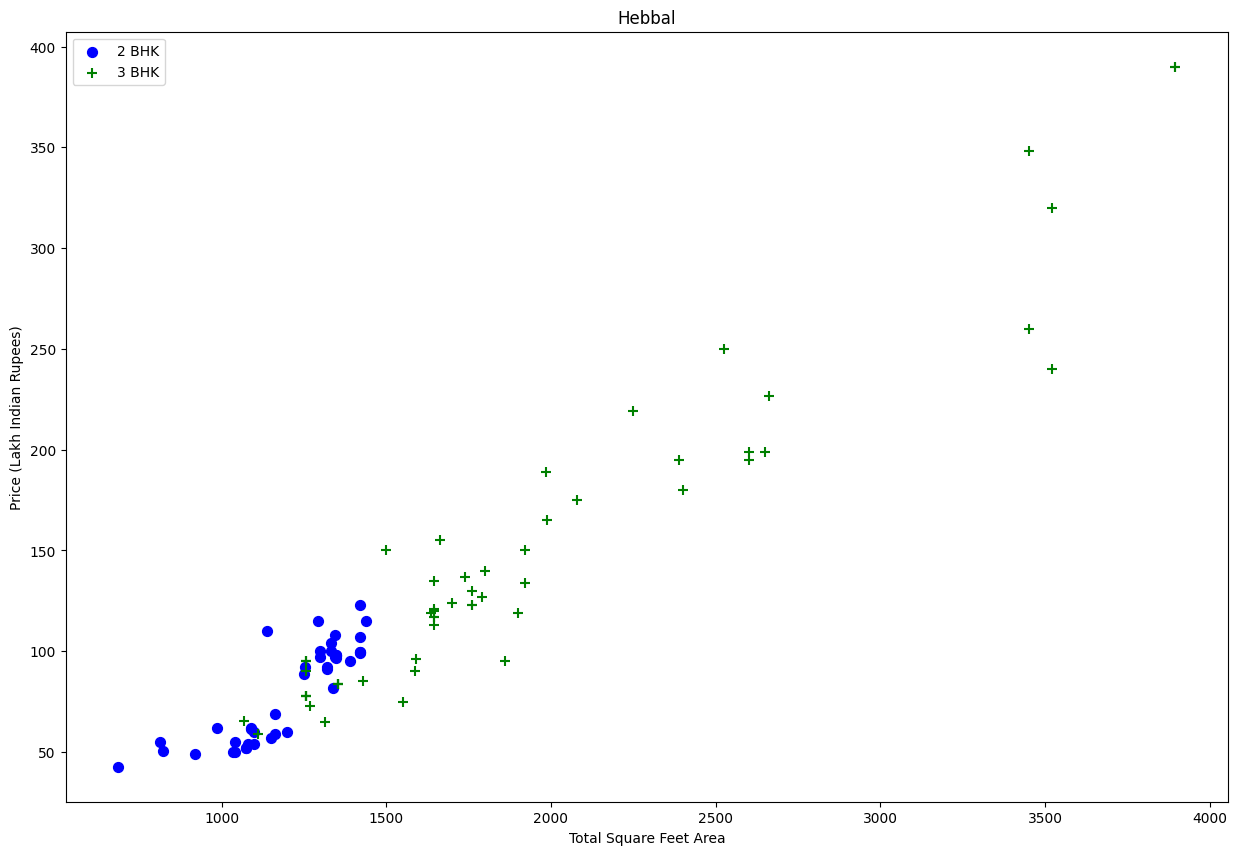

In [65]:
plot_scatter_chart(df,"Hebbal")

We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.
```
{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}
```
Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment

In [66]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df = remove_bhk_outliers(df)
df.shape

(6984, 6)

Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties

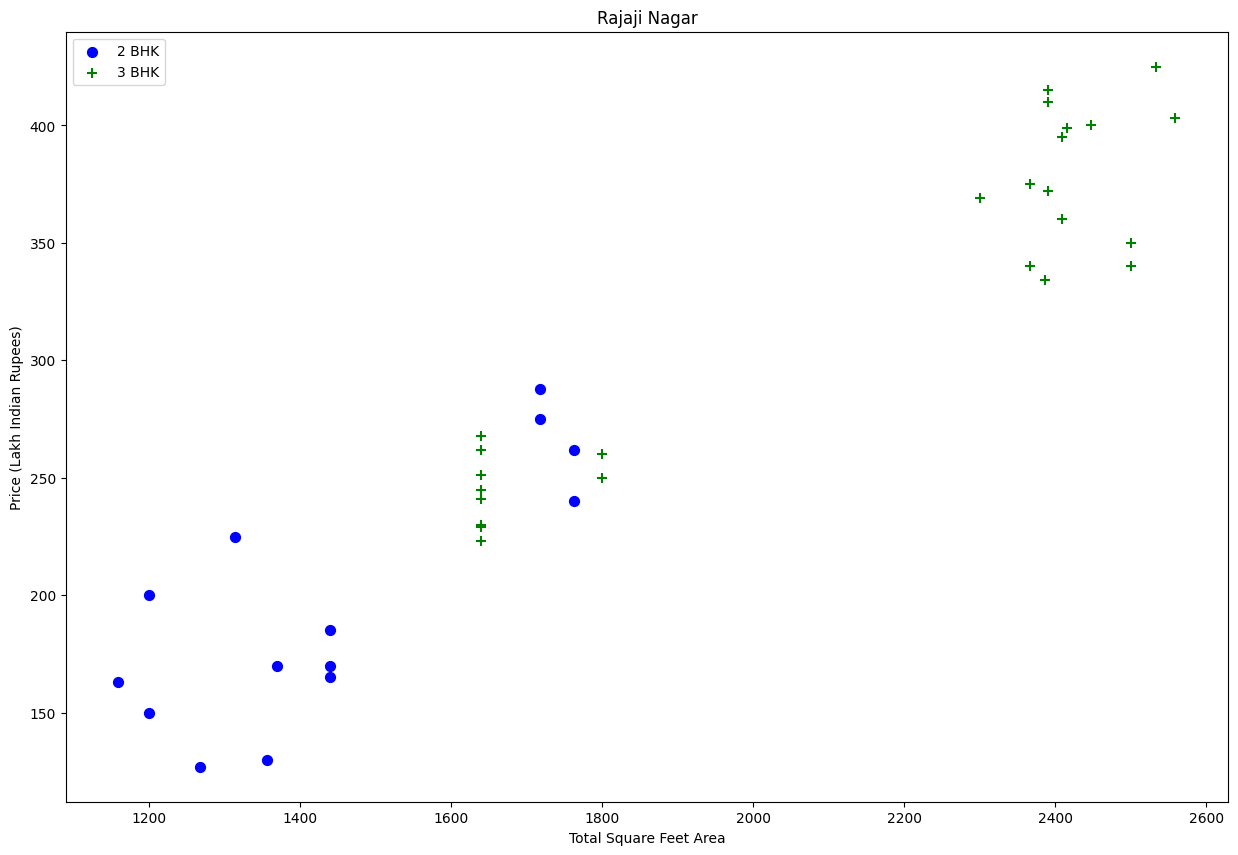

In [67]:
plot_scatter_chart(df,"Rajaji Nagar")

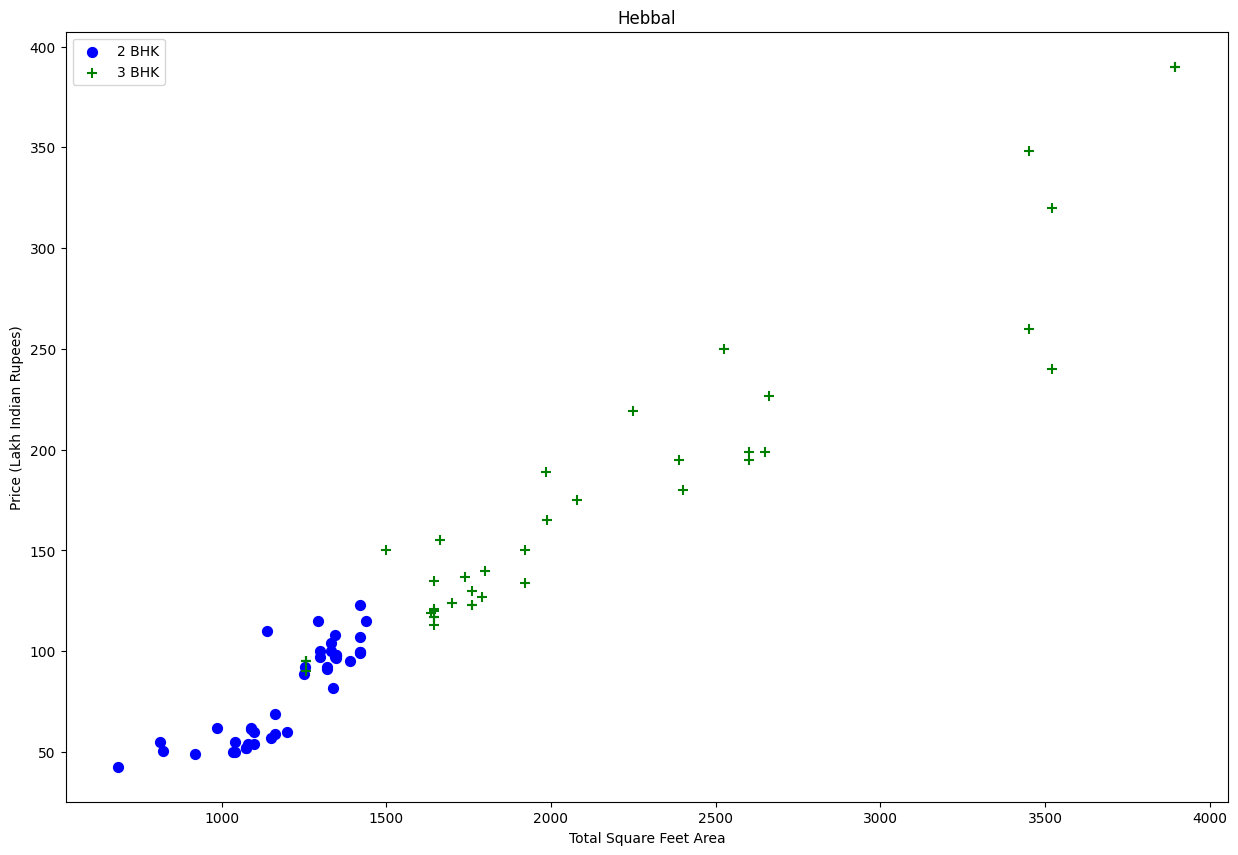

In [68]:
plot_scatter_chart(df,"Hebbal")

Based on above charts we can see that data points highlighted in red below are outliers and they are being removed due to remove_bhk_outliers function

<h3 style='color:orange'>Before and after outlier removal: Rajaji Nagar</h3>

<img src="../results/rajaji_nagar_outliers.png"></img>

<h3 style='color:orange'>Before and after outlier removal: Hebbal</h3>

<img src="../results/hebbal_outliers.png"></img>

Text(0, 0.5, 'Count')

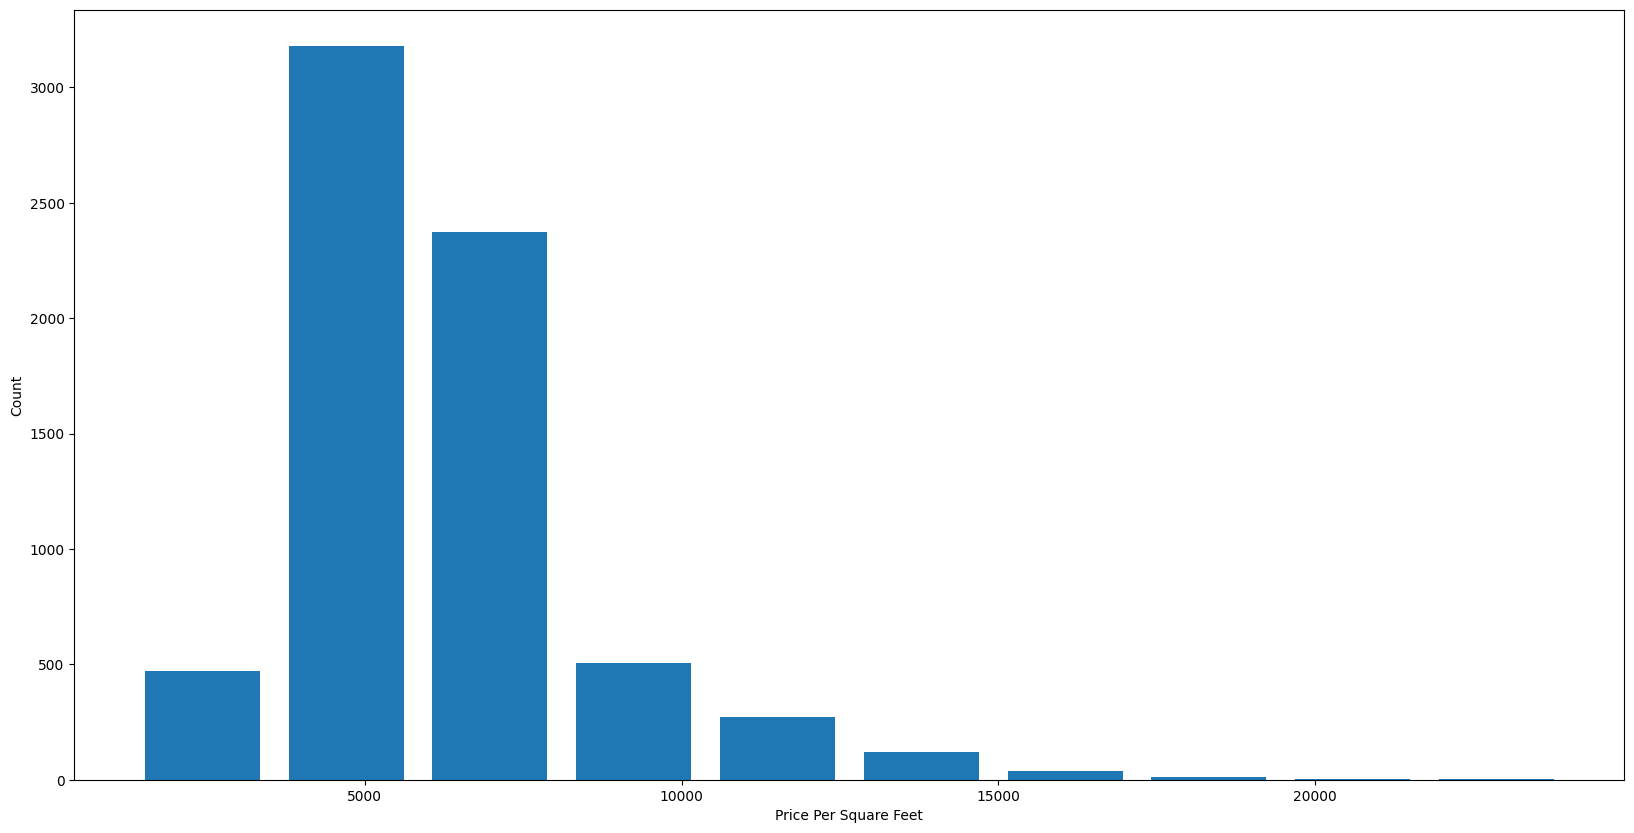

In [69]:
plt.rcParams["figure.figsize"] = (20,10)
plt.hist(df.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

<h3 style='color:white'>Outlier Removal Using Bathrooms Feature</h3>

In [70]:
df.bath.unique()

array([ 3.,  5.,  4.,  2.,  1.,  6.,  8.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

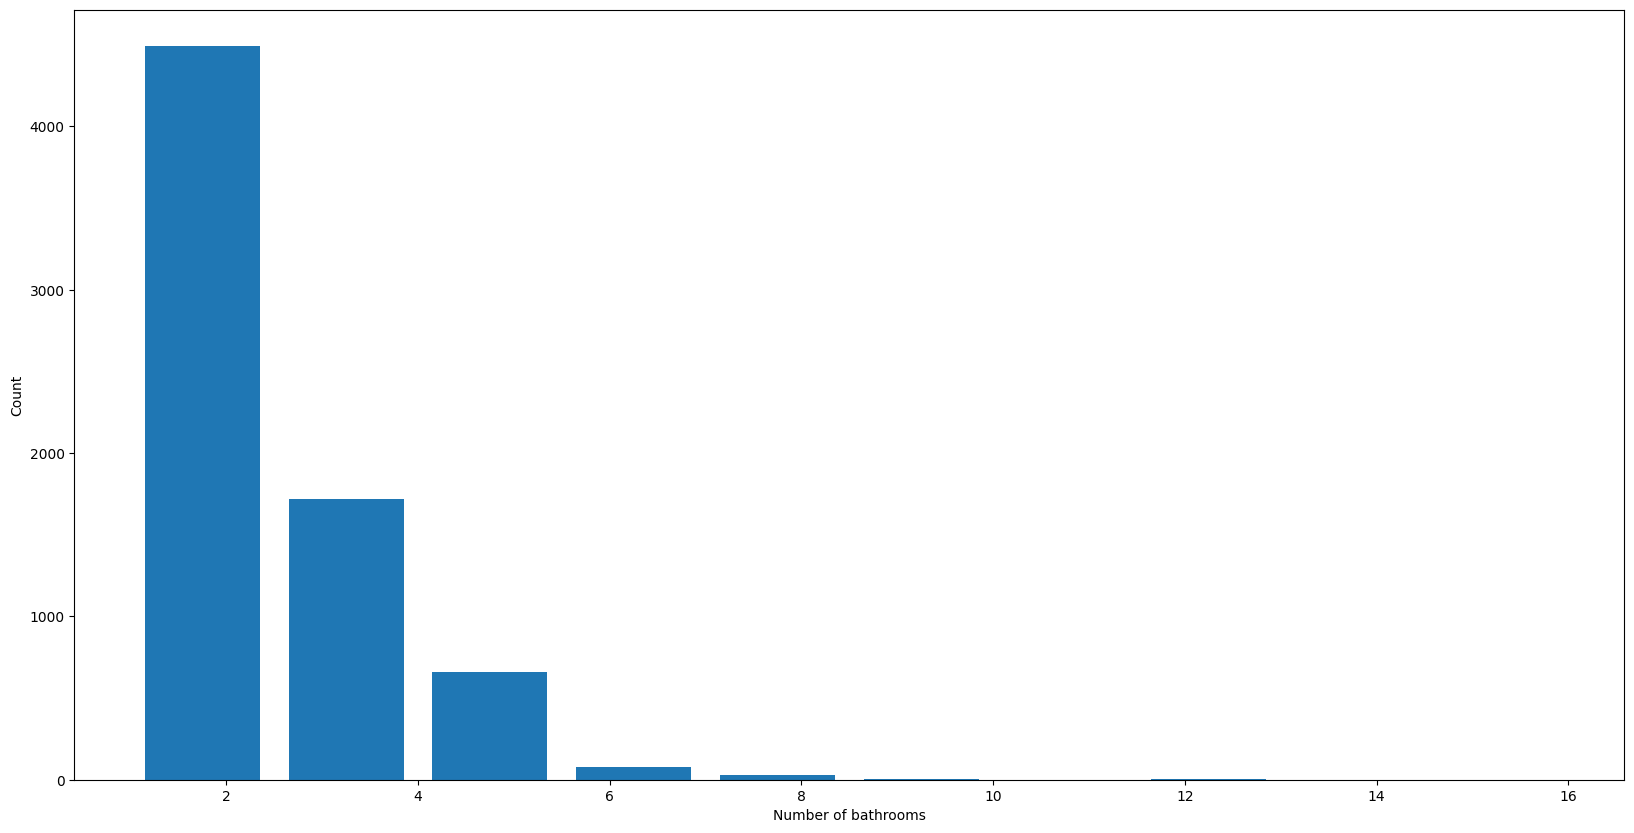

In [71]:
plt.hist(df.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [72]:
df[df.bath>10]

,location,total_sqft,bath,price,bhk,price_per_sqft
4951,Neeladri Nagar,4000.0,12.0,160.0,10,4000.000000
8031,other,12000.0,12.0,525.0,10,4375.000000
8130,other,10000.0,16.0,550.0,16,5500.000000
8915,other,6000.0,12.0,150.0,11,2500.000000
9275,other,5425.0,13.0,275.0,13,5069.124424


It is unusual to have 2 more bathrooms than number of bedrooms in a home

In [73]:
df[df.bath>df.bhk+2]

,location,total_sqft,bath,price,bhk,price_per_sqft
1488,Chikkabanavar,2460.0,7.0,80.0,4,3252.032520
6292,Thanisandra,1806.0,6.0,116.0,3,6423.034330
7947,other,11338.0,9.0,1000.0,6,8819.897689
9552,other,7000.0,8.0,450.0,4,6428.571429


Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed

In [74]:
df = df[df.bath<df.bhk+2]
df.shape

(6906, 6)

In [75]:
df.head(5)

,location,total_sqft,bath,price,bhk,price_per_sqft
1,1st Phase JP Nagar,1875.0,3.0,167.0,3,8906.666667
2,1st Phase JP Nagar,1500.0,5.0,85.0,5,5666.666667
3,1st Phase JP Nagar,2065.0,4.0,210.0,3,10169.491525
5,1st Phase JP Nagar,2059.0,3.0,225.0,3,10927.634774
6,1st Phase JP Nagar,1394.0,2.0,100.0,2,7173.601148


In [76]:
df = df.drop(['price_per_sqft'],axis='columns')
df.head(5)

,location,total_sqft,bath,price,bhk
1,1st Phase JP Nagar,1875.0,3.0,167.0,3
2,1st Phase JP Nagar,1500.0,5.0,85.0,5
3,1st Phase JP Nagar,2065.0,4.0,210.0,3
5,1st Phase JP Nagar,2059.0,3.0,225.0,3
6,1st Phase JP Nagar,1394.0,2.0,100.0,2


# Save The FE data 

In [77]:
df.to_csv('../data/v4_Feature_Engineering.csv', index=False)

### This is for ```src/components/d_feature_engineering.py```

In [79]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

def feature_engineering(df):
    """
    This function performs feature engineering on the input DataFrame by creating new features
    and modifying existing ones to enhance the dataset for analysis or modeling.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing real estate data.

    Returns:
    pd.DataFrame: The modified DataFrame with new features.
    """
    # Create a new feature 'price_per_sqft'
    df['price_per_sqft'] = df['price'] * 100000 / df['total_sqft']

    # Remove outliers based on price_per_sqft
    df = remove_pps_outliers(df)

    # Remove outliers based on bhk
    df = remove_bhk_outliers(df)

    # Standardize location names by stripping whitespace
    df.location = df.location.apply(lambda x: x.strip())

    # Group by location to count occurrences
    location_stage = df.groupby('location')['location'].agg('count').sort_values(ascending=False)

    # Identify locations with 10 or fewer data points
    location_stage_less_then_10 = location_stage[location_stage <= 10]

    # Replace less frequent locations with 'other'
    df.location = df.location.apply(lambda x: 'other' if x in location_stage_less_then_10 else x)

    return df